## TimSim DIA 

This notebook breaks down the current `timsim` cmd tool into its core components, leaving out the final step where simulated data is written to a TDF file. It creates a playground for the implementation of a simulated DIA acquisition.

### Step 1: Create a new synthetic experiment 

We start by setting up the required databases and raw files, allowing interaction with three core datasets:

```text
EXAMPLE/
├── EXAMPLE.d/
│   ├── analysis.tdf         ← SQLite metadata database (Bruker format)
│   └── analysis.tdf_bin     ← Binary frames (Bruker format)
└── synthetic_data.db        ← Simulation blueprint (custom)
```

- `analysis.tdf`: SQLite database in a `.d` folder, simulating metadata for a timsTOF raw dataset  
- `analysis.tdf_bin`: Binary block holding raw frames, initially empty  
- `synthetic_data.db`: SQLite database storing a simulation blueprint with tables describing ion distributions

In [2]:
from imspy.simulation.timsim.jobs.build_acquisition import build_acquisition

# give a path to a reference dataset (real data TDF folder)
ref_path = "/media/hd02/data/raw/dia/blanks/blanks-dia-PASEF/G241217_012_Slot2-2_1_16313.d/"

# give a path where data will be put into
save_path = "."

# 30 minutes gradient
gradient_length = 30 * 60

# helper function that sets up paths and creates a handle that can connect to the real bruker dataset,
# the simulated bruker dataset, and the simulation blueprint
acquisition_builder = build_acquisition(
    path=save_path,
    reference_path=ref_path,
    exp_name="T001",
    acquisition_type='DIA',
    verbose=False,
    # gradient length should be given in seconds
    gradient_length=gradient_length,
)

Connecting to database: T001/synthetic_data.db


### Step 2: Create proteins table where peptides will be sampled from
Next, a set of proteins is sampled from a given FASTA file and synthetically digested and associated with an occurence value.
In the long run, this step will offer more options for how peptides are sampled from proteins and how to define the occurence; for now, sampling is done randomly and occurence sampling is done using a custom hokey-stick distribution which we derived experimentally.

In [3]:
from imspy.simulation.timsim.jobs.simulate_proteins import simulate_proteins

# create collection of proteins, create peptides to be taken from proteins
proteins = simulate_proteins(
    fasta_file_path="/media/hd02/data/fasta/hela/plain/hela.fasta",
    # if requested num proteins is larger than number of proteins in file, take all
    n_proteins=5000,
    cleave_at="KR",
    restrict="P",
    missed_cleavages=2,
    min_len=7,
    # max length is currently dictated by prosit intensity predictor maximum
    max_len=30,
    generate_decoys=False,
    # request modifications UNIMOD style
    variable_mods={"[": ["[UNIMOD:1]"]},
    static_mods={"C": "[UNIMOD:4]"},
    verbose=True,
)

Sampling 5000 proteins from the FASTA file.


### Step 3: Create peptides table 
Next, a collection of peptides is generated. When randomly sampling peptides from a synthetic digest, many of the selected peptides may have very low predicted retention times, leading to an imbalance in the distribution and increasing the workload when building frames later.
To address this, the peptide table generation step allows for balancing peptide occurrences across the retention time gradient of the experiment.

In [5]:
from imspy.simulation.timsim.jobs.simulate_peptides import simulate_peptides

# simulate peptides
peptides = simulate_peptides(
    protein_table=proteins,
    num_peptides_total=5000,
    verbose=True,
    exclude_accumulated_gradient_start=True,
    min_rt_percent=2.0,
    gradient_length=acquisition_builder.gradient_length,
    down_sample=True,
    proteome_mix=False,
)

# extract relevant columns from proteins
proteins = proteins[["protein_id", "protein", "sequence", "events"]]
# Save proteins to sqlite table
acquisition_builder.synthetics_handle.create_table(table_name='proteins', table=proteins)

Simulating retention times for peptides and filtering...
Excluded 0 peptides with low retention times.


### Step 4: Predict retention times for peptides

After the peptides are selected, their retention times are simulated using a neural network.
In the long run, it would be ideal to design the simulator in a way that allows models to be easily swapped out.

In [6]:
from imspy.simulation.timsim.jobs.simulate_retention_time import simulate_retention_times

peptides = simulate_retention_times(
    peptides=peptides,
    verbose=True,
    gradient_length=acquisition_builder.gradient_length,
)

columns = list(peptides.columns)
# The last two might be 'events' and 'retention_time_gru_predictor' or some similar swap:
columns[-2], columns[-1] = columns[-1], columns[-2]
peptides = peptides[columns]

Simulating retention times...
4/4 [==============================] - 1s 12ms/step


### Step 5: Create a full retention time distribution

Predicting point estimates for retention times is not sufficient.
Peptides need to be represented by full distributions in the retention time dimension, modeled here using an Exponentially Modified Gaussian (EMG) distribution.
This step provides a few hyperparameters to introduce slight variability into the individual distributions.

In [8]:
from imspy.simulation.timsim.jobs.simulate_frame_distributions_emg import simulate_frame_distributions_emg

peptides = simulate_frame_distributions_emg(
    peptides=peptides,
    frames=acquisition_builder.frame_table,
    rt_cycle_length=acquisition_builder.rt_cycle_length,
    target_p=0.9999,
    step_size=0.001,
    sigma_alpha_rt=4,
    sigma_beta_rt=4,
    k_lower_rt=0,
    k_upper_rt=10,
    k_alpha_rt=1,
    k_beta_rt=20,
    verbose=True,
    add_noise=False,
    num_threads=16,
    from_existing=False,
    sigmas=None,
    lambdas=None,
    sigma_lower_rt=None,
    sigma_upper_rt=None,
    gradient_length=gradient_length,
)

# After the full distributions are created, the peptides table can be saved to the sqlite database
acquisition_builder.synthetics_handle.create_table(table_name='peptides', table=peptides)

Calculating frame distributions...
sigma_lower: 1.125, sigma_upper: 1.875, sigma_alpha: 4, sigma_beta: 4
Serializing frame distributions to json...


### Step 6: Synthetically ionize, mobility-separate, and distribute peptides

Following the same approach used to generate retention time distributions, the next steps combine machine learning models and distribution-based calculations to produce an ions table.
For conciseness, these operations are grouped into a single step.

In [9]:
from imspy.simulation.timsim.jobs.simulate_charge_states import simulate_charge_states
from imspy.simulation.timsim.jobs.simulate_ion_mobilities_and_variance import simulate_ion_mobilities_and_variance
from imspy.simulation.timsim.jobs.simulate_precursor_spectra import simulate_precursor_spectra_sequence
from imspy.simulation.timsim.jobs.simulate_scan_distributions_with_variance import simulate_scan_distributions_with_variance

# create charge states
ions = simulate_charge_states(
    peptides=peptides,
    mz_lower=acquisition_builder.tdf_writer.helper_handle.mz_lower,
    mz_upper=acquisition_builder.tdf_writer.helper_handle.mz_upper,
    p_charge=0.8,
    max_charge=4,
    use_binomial=True,
    min_charge_contrib=0.05,
)

# get ion-mobilities and variances
ions = simulate_ion_mobilities_and_variance(
    ions=ions,
    im_lower=acquisition_builder.tdf_writer.helper_handle.im_lower,
    im_upper=acquisition_builder.tdf_writer.helper_handle.im_upper,
    verbose=True,
    remove_mods=True,
    use_target_mean_std=True,
    target_std_mean=0.006,
)

# get precursor isotopic distributions
ions = simulate_precursor_spectra_sequence(
    ions=ions,
    num_threads=16,
    verbose=True,
)

# get scan distributions total
ions = simulate_scan_distributions_with_variance(
    ions=ions,
    scans=acquisition_builder.scan_table,
    verbose=True,
    p_target=0.9999,
    add_noise=False,
    num_threads=16,
)

# save ions
acquisition_builder.synthetics_handle.create_table(table_name='ions', table=ions)

flatmap charges: 100%|███████████████████| 3669/3669 [00:00<00:00, 26404.98it/s]


Simulating ion mobilities and variance...
5/5 [==============================] - 1s 22ms/step
Standard deviation distribution apex was shifted from 0.0067 to 0.0060
Simulating sequence specific precursor isotopic distributions ...
Serializing simulated spectra to json...
Calculating scan distributions...
Calculating scan occurrences...
Calculating scan abundances...
Serializing scan distributions to json...


### Simulate Fragment Ion Intensities

In case of DIA acquisition, the sampling of precursors from the ion-cloud is simpler compared to DDA, since one does not need to simulate the online selection of precursors. The simulation simply cycles through the selection settings of the layout that was defined prior to the data recording. 

The simulation of fragment intensities is performed only for precursor ions that are actually selected for fragmentation. This step was introduced to improve simulation efficiency — without it, a large amount of fragmentation data would be simulated unnecessarily for ions that are never selected for fragmentation.

Only after this selection step is performed can we proceed to simulate the fragment frames.

In [11]:
from imspy.simulation.timsim.jobs.simulate_fragment_intensities import simulate_fragment_intensities

# JOB 9: Simulate fragment intensities
simulate_fragment_intensities(
    path=".",
    name="T001",
    acquisition_builder=acquisition_builder,
    batch_size=256,
    verbose=True,
    num_threads=16,
    down_sample_factor=.5,
    dda=False
)

Simulating fragment ion intensity distributions...
Calculating precursor ion transmissions and collision energies...


Simulating intensities: 100%|█████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


Mapping fragment ion intensity distributions to b and y ions...


flattening prosit predicted intensities: 100%|████████████████████████| 1/1 [00:01<00:00,  1.98s/it]


### Create the TDF Dataset

Everything is now set-up for the full simulation, generating the synthetic TDF that can be passed to other software afterwards.

In [12]:
from imspy.simulation.timsim.jobs.assemble_frames import assemble_frames

# Assemble frames, write the frames to a synthetic TDF file
assemble_frames(
    acquisition_builder=acquisition_builder,
    frames=acquisition_builder.frame_table,
    batch_size=512,
    verbose=False,
    mz_noise_precursor=True,
    mz_noise_uniform=True,
    precursor_noise_ppm=5.0,
    mz_noise_fragment=True,
    fragment_noise_ppm=5.0,
    num_threads=16,
    add_real_data_noise=True,
    intensity_max_precursor=1500,
    intensity_max_fragment=1500,
    precursor_sample_fraction=0.2,
    fragment_sample_fraction=0.2,
    num_precursor_frames=5,
    num_fragment_frames=5,
    fragment=True,
)

frame assembly: 100%|███████████████████████████████████████████████| 34/34 [02:13<00:00,  3.93s/it]


Error writing PasefFrameMsMsInfo table: Execution failed on sql 'SELECT * from PasefFrameMsMsInfo': no such table: PasefFrameMsMsInfo


### Visualize a Window Group

In [16]:
import numpy as np
from imspy.timstof.dia import TimsDatasetDIA
from imspy.simulation.acquisition import SyntheticExperimentDataHandle

# create a data handle to the RAW data
ds_name = "T001"
data = TimsDatasetDIA("T001/T001.d")

# create a database handle to the simulation meta data database
handle = SyntheticExperimentDataHandle("T001/")
SIM_peptides = handle.get_table("peptides")

Connecting to database: T001/synthetic_data.db


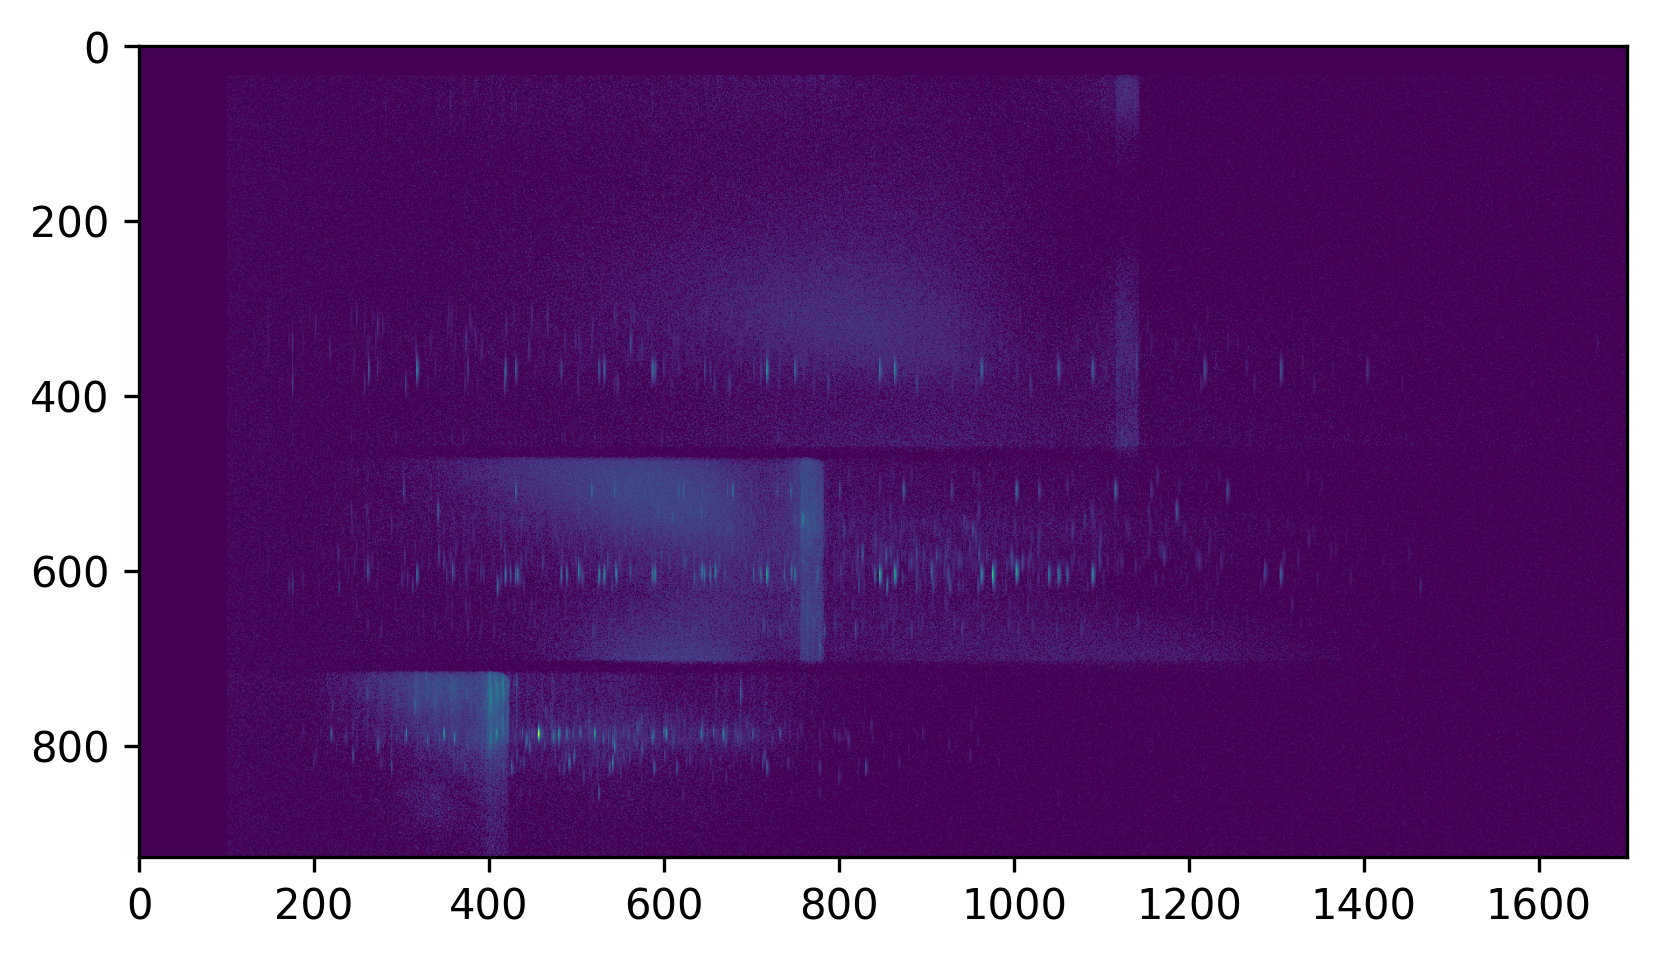

In [31]:
from tensorflow import sparse as sp

# extract one window group from the raw data
wg = data.dia_ms_ms_info[data.dia_ms_ms_info.WindowGroup == 5].Frame.values[100:1000]

# extract the raw frames
frames = data.get_tims_slice(wg)

# project the collection of frames into 2D pixel grid
frames_dense = frames.vectorized(0).get_tensor_repr(re_index=False, zero_index=False, dense=False)
D = sp.reduce_sum(frames_dense, axis=0).numpy()

# visualize
from matplotlib import pyplot as plt

plt.figure(dpi=300)
plt.imshow(np.cbrt(D))
plt.show()